In [2]:
import sys
sys.path.insert(1, '..')
from utils import *

%matplotlib inline

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

AREA_NAME = 'NYC'

In [4]:
bdir = join(pwd, dpath, 'area-pois', AREA_NAME)
poi_df = pd.concat([pd.read_csv(join(bdir, f)) for f in os.listdir(bdir)], axis=0).drop_duplicates(subset=['safegraph_place_id'])
sgid2cat = dict(zip(poi_df.safegraph_place_id, poi_df.top_category))

In [5]:
def visits_from_borough(visits, borough_code):
    total_visits = 0
    visit_counts = json.loads(visits)
    for cbg in visit_counts:
        if cbg[:5] == borough_code:
            total_visits += visit_counts[cbg]
    return total_visits

In [6]:
ptype = 'filtered-patterns-msa'
patterns_dir = join(pwd, dpath, ptype, f'{AREA_NAME}-patterns')

wlst = []
for pfile in tqdm(os.listdir(patterns_dir)):
    df = pd.read_csv(join(patterns_dir, pfile))
    
    for bcode, bname in nyc_borough_fips_codes.items():
        df['nvisits'] = df.visitor_home_cbgs.apply(visits_from_borough, borough_code=str(bcode))
        bdf = df[df.nvisits > 0]
        
        bdf['home_borough'] = bname
        bdf['date'] = pfile.split('.')[0]
        bdf['category'] = bdf.safegraph_place_id.map(sgid2cat)
        bdf['borough'] = (bdf.poi_cbg // 10**7).apply(lambda x: nyc_borough_fips_codes[x] if x in nyc_borough_fips_codes else 'other')
        
        cat_visit_by_borough = bdf.groupby(['category', 'home_borough', 'date', 'borough']).sum()[['nvisits']]
        cat_visit_by_borough['nvisits_ratio'] = cat_visit_by_borough['nvisits'] / cat_visit_by_borough['nvisits'].sum(level=0)
        wlst.append(cat_visit_by_borough)
        
dd = pd.concat(wlst, axis=0)
dd.to_csv(join(pwd, util_datasets, 'ny-msa-poi-visits-v2.csv'))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [14:02<00:00,  7.87s/it]


In [16]:
df = pd.read_csv(join(pwd, util_datasets, 'ny-msa-poi-visits-v2.csv'))
df['date'] = pd.to_datetime(df['date'])

In [17]:
borough_colors = {
    'Staten Island': '#e41a1c',
    'Manhattan': '#377eb8',
    'Bronx': '#4daf4a',
    'Brooklyn': '#984ea3',
    'Queens': '#ff7f00',
    'other': '#e6ab02'
}

In [33]:
fig_visit_pct_dir = join(FIG_SAVE_DIR, 'visit_pct_dir')
if not exists(fig_visit_pct_dir):
    os.mkdir(fig_visit_pct_dir)
    
result_visit_pct_dir = join(RESULT_SAVE_DIR, 'visit_pct_dir')
if not exists(result_visit_pct_dir):
    os.mkdir(result_visit_pct_dir)

In [32]:
periods = {
    'before-covid': {
        'begin-date': datetime(2018, 1, 1),
        'end-date': datetime(2020, 2, 28),
    },
    'first-phase': {
        'begin-date': datetime(2020, 3, 1),
        'end-date': datetime(2020, 6, 8)
    },
    'summer-term': {
        'begin-date': datetime(2020, 6, 8),
        'end-date': datetime(2020, 10, 30)
    }
}

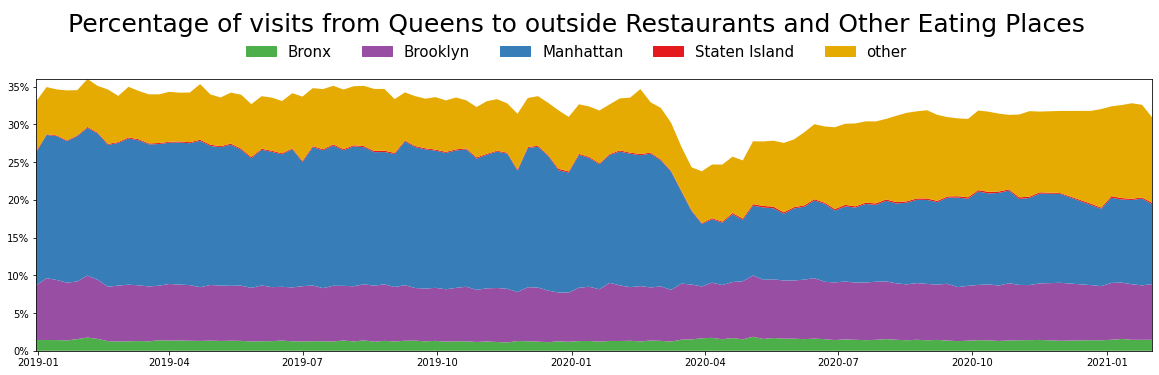

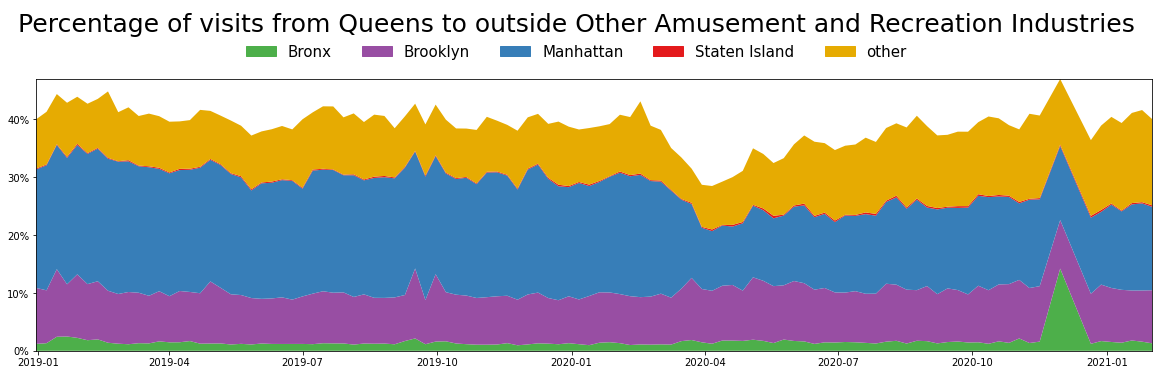

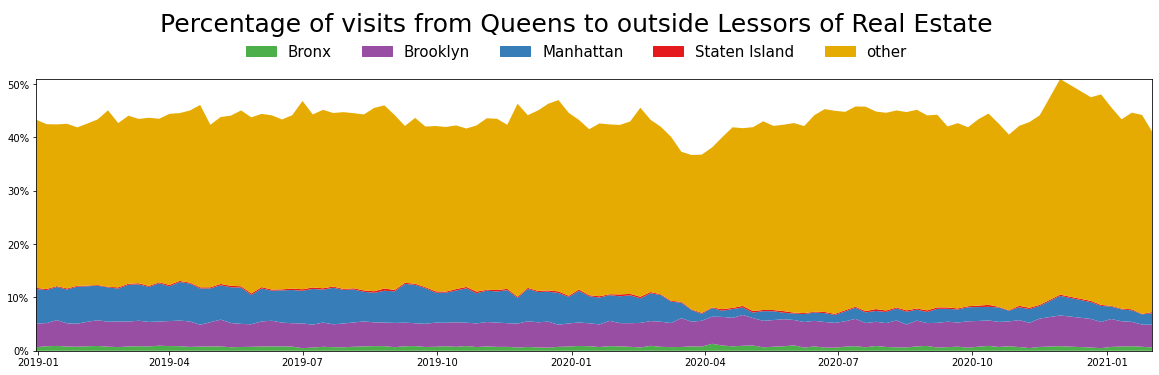

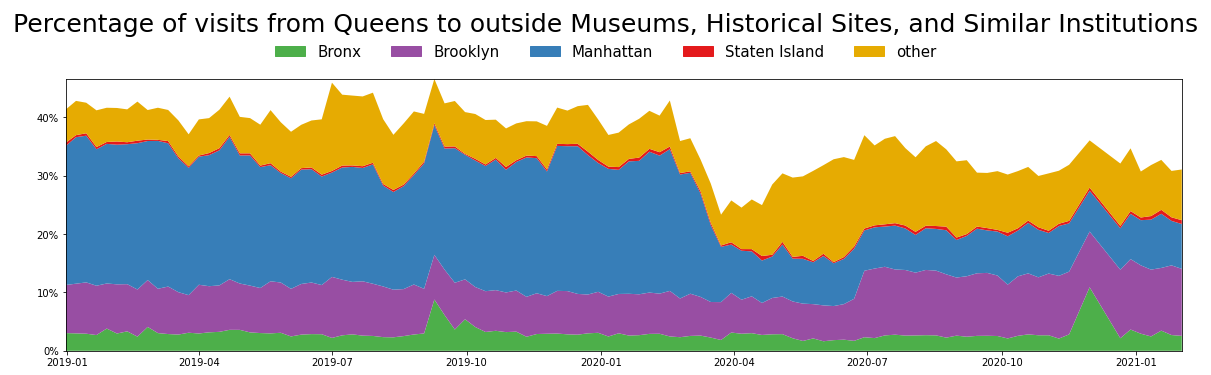

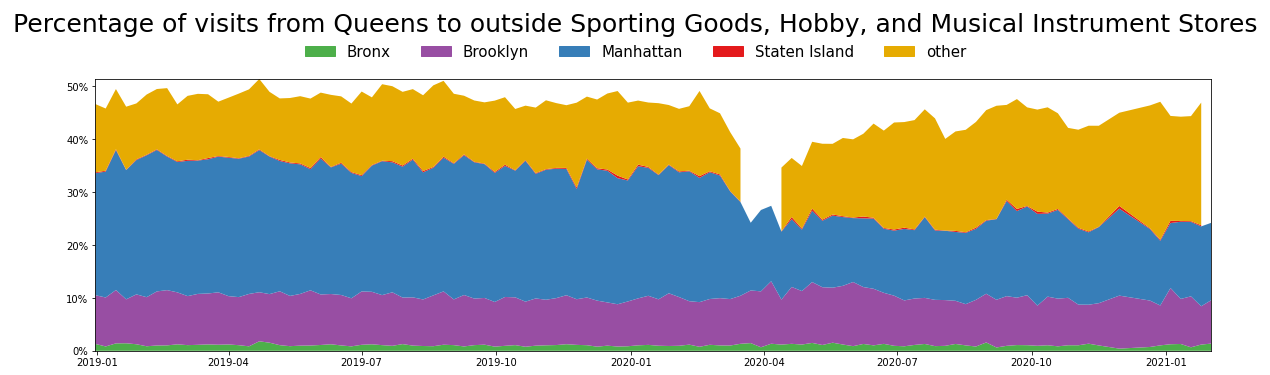

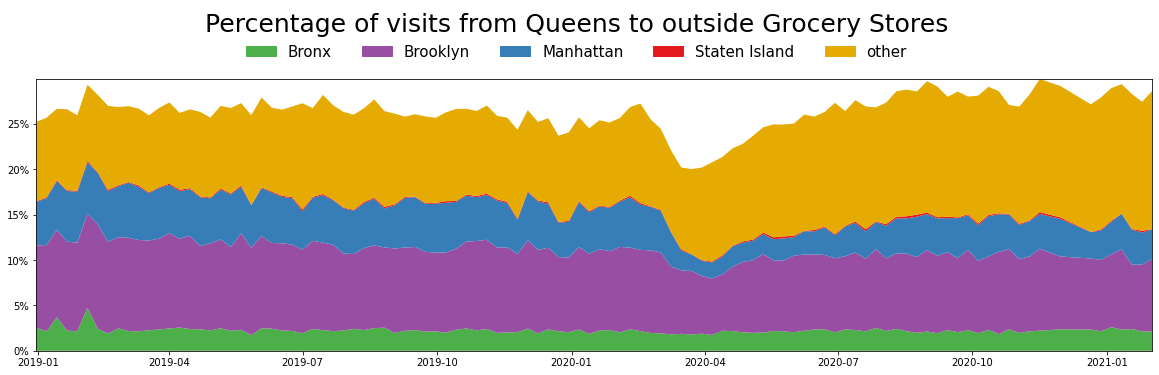

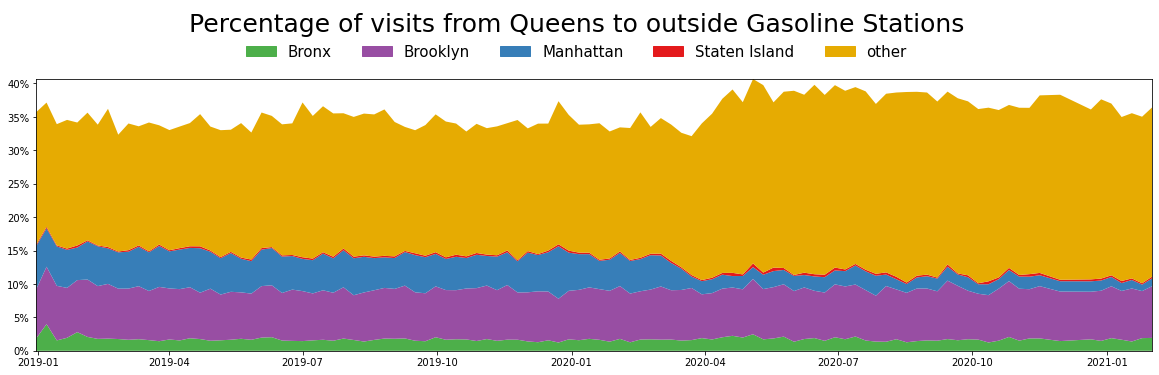

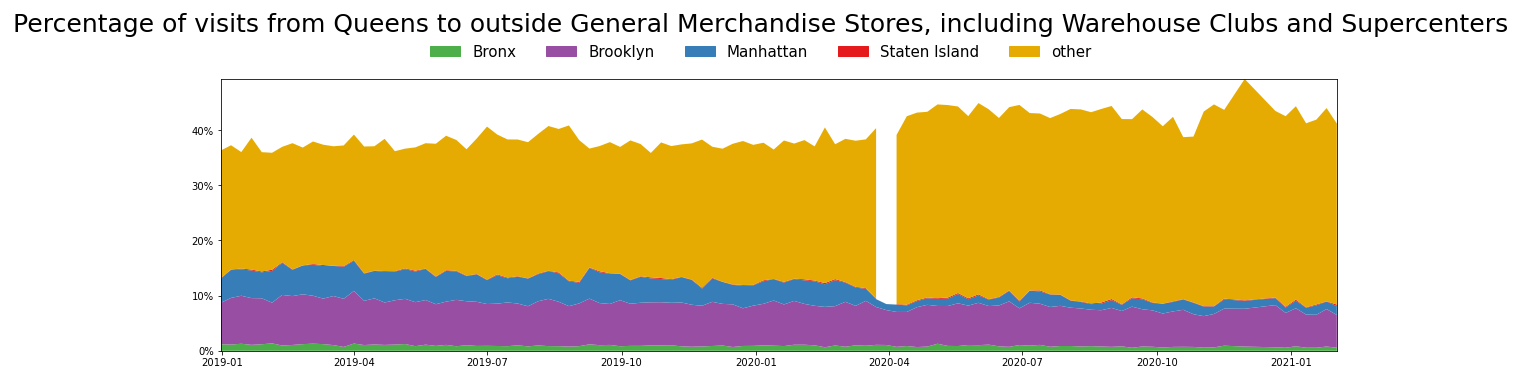

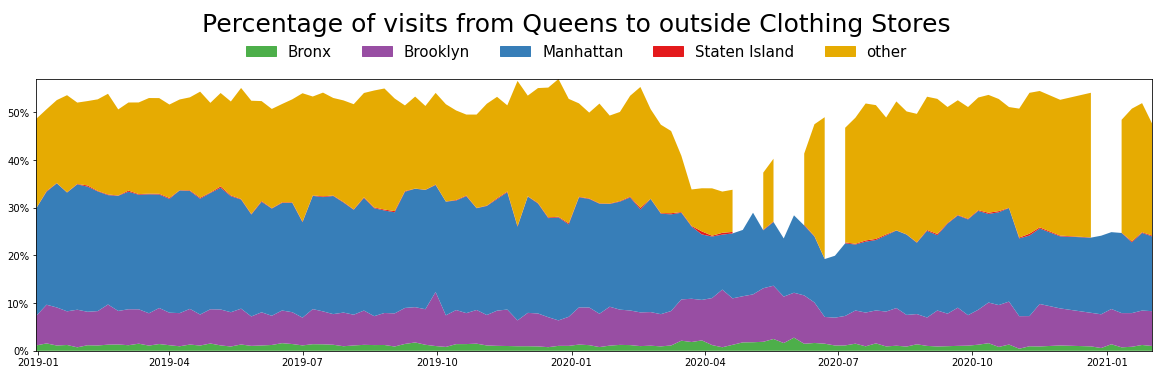

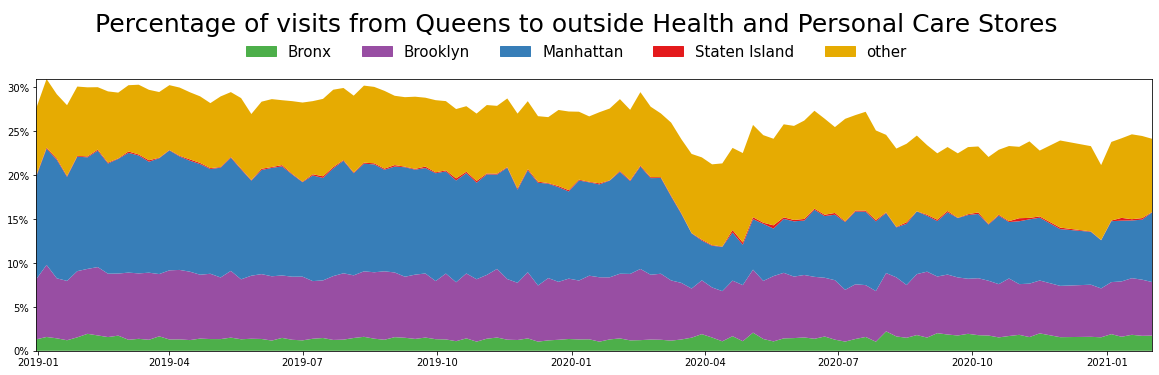

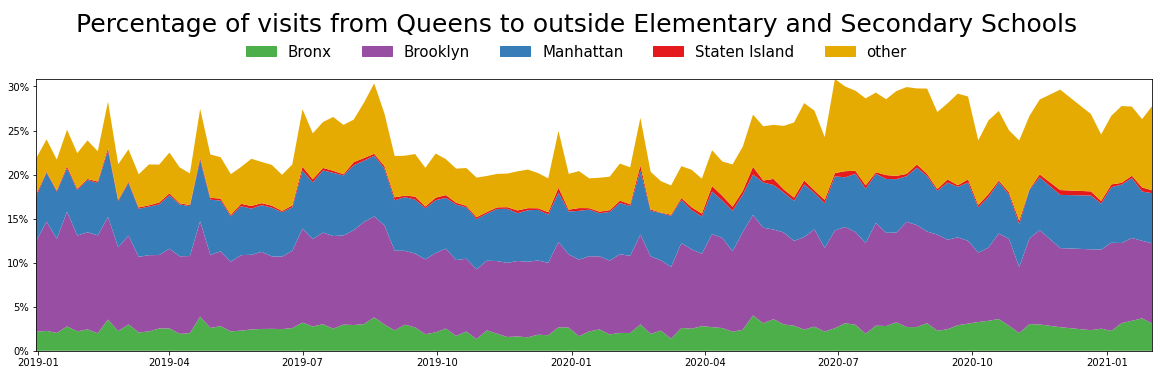

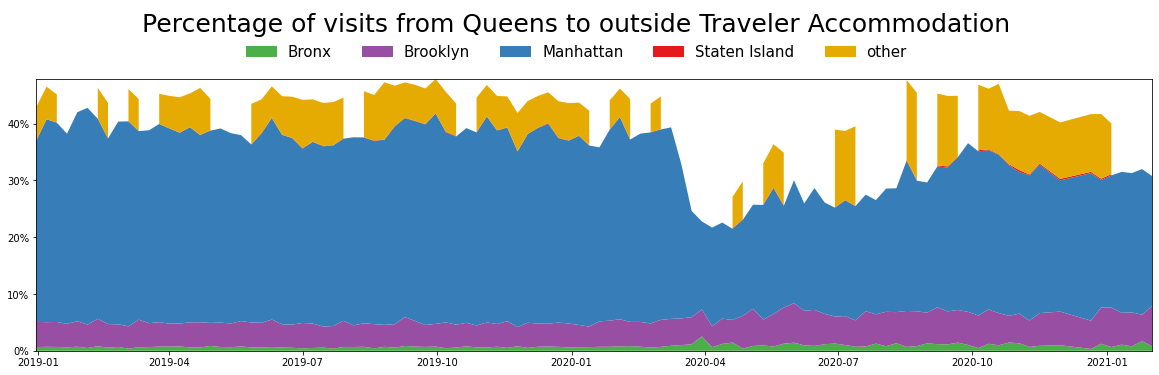

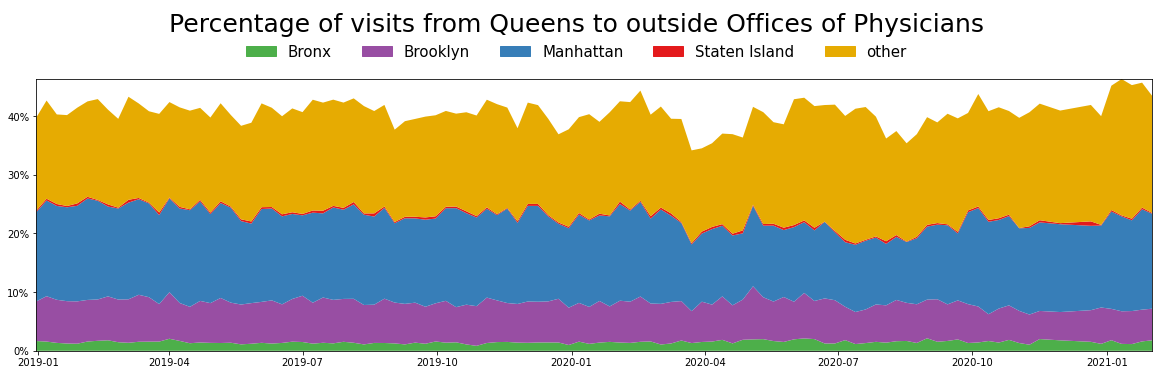

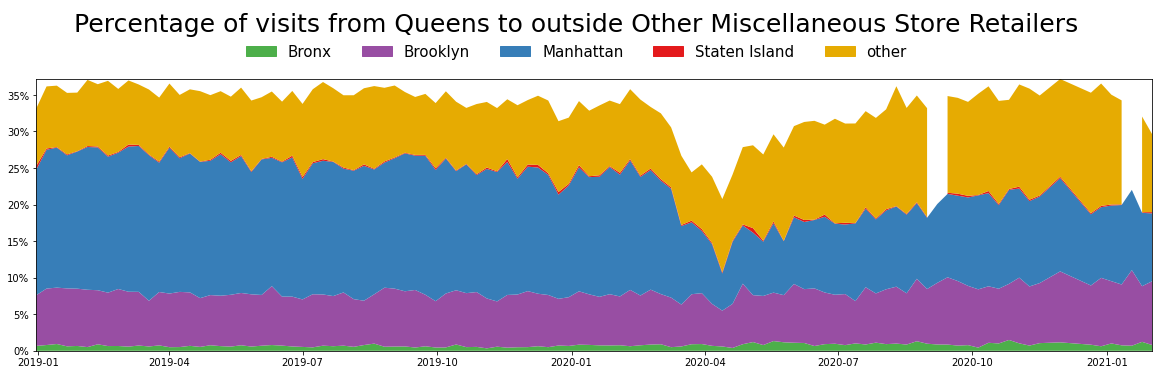

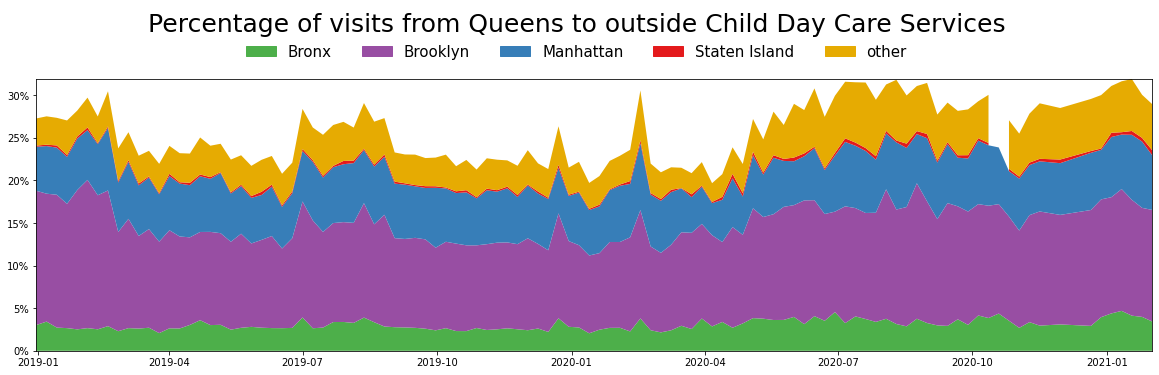

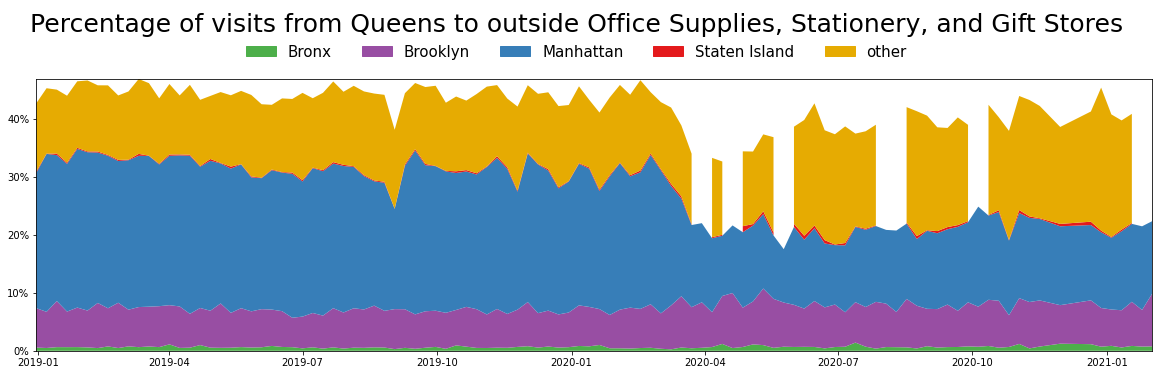

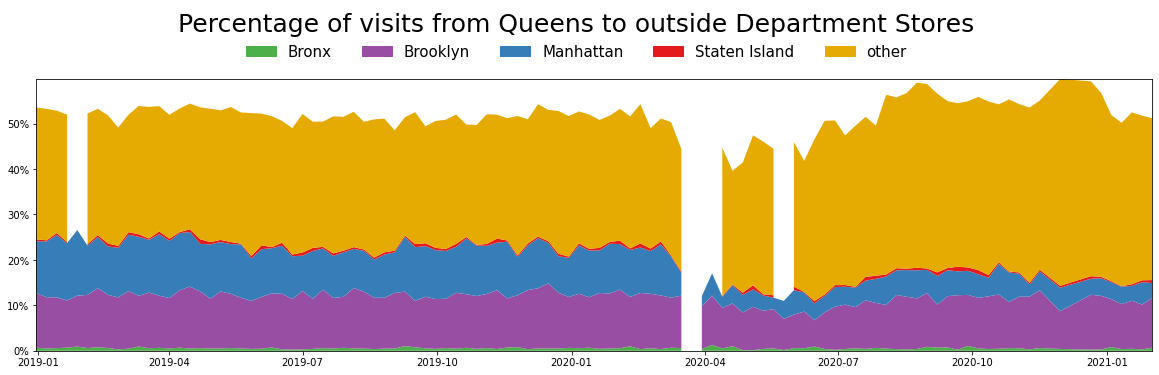

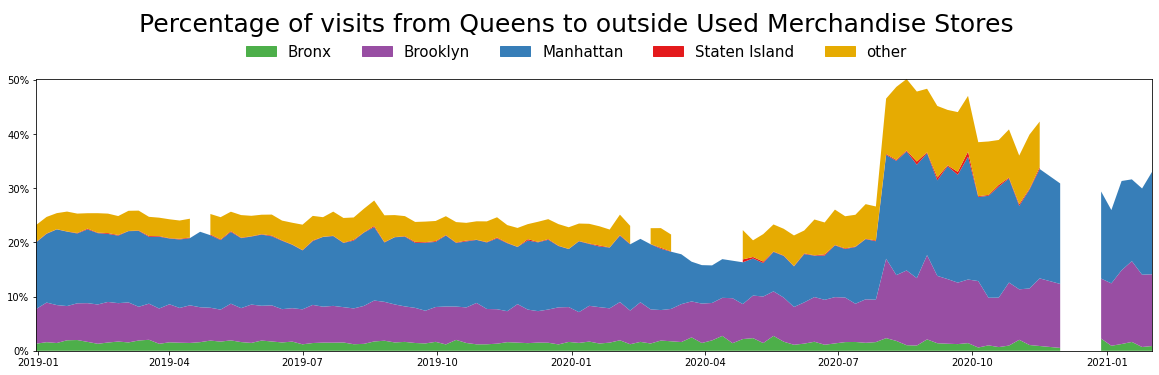

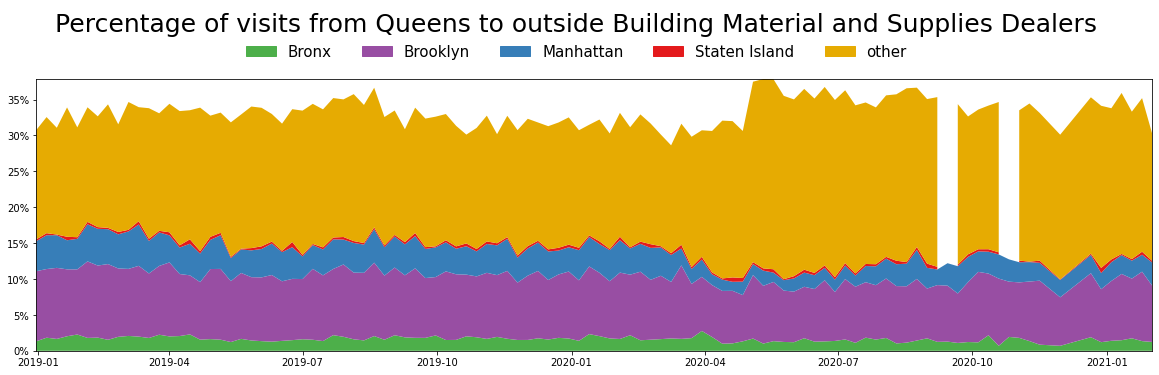

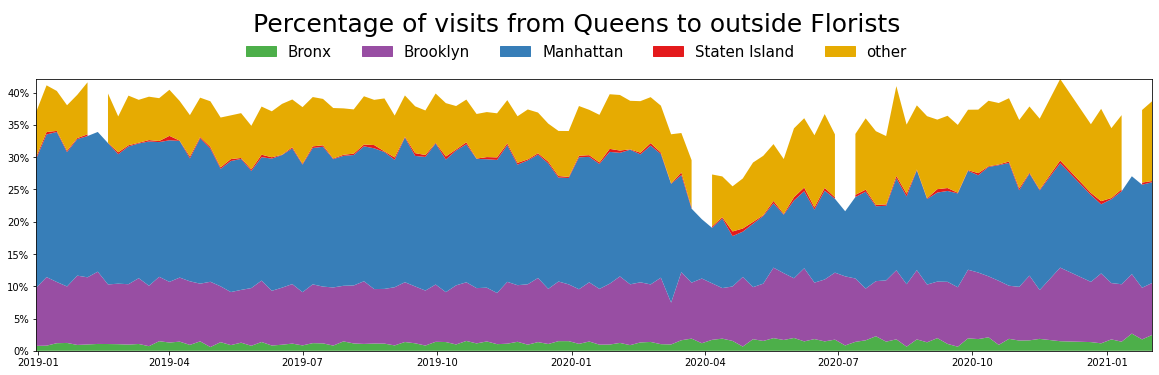

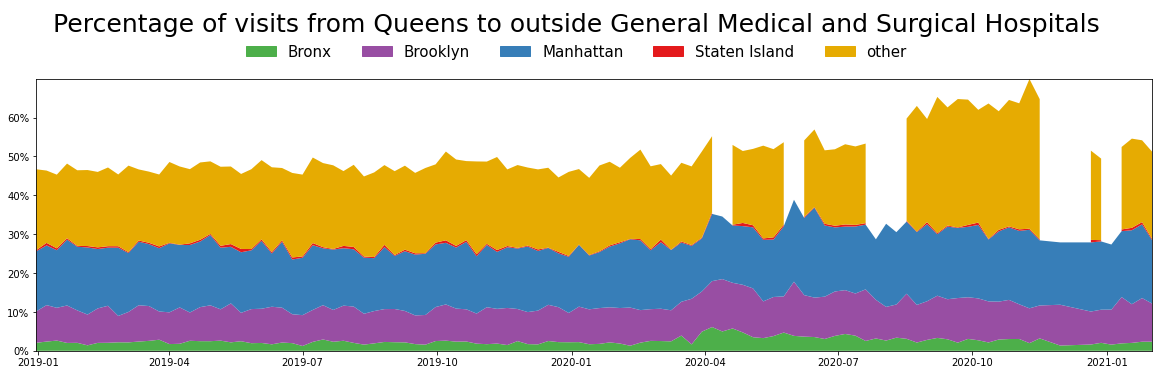

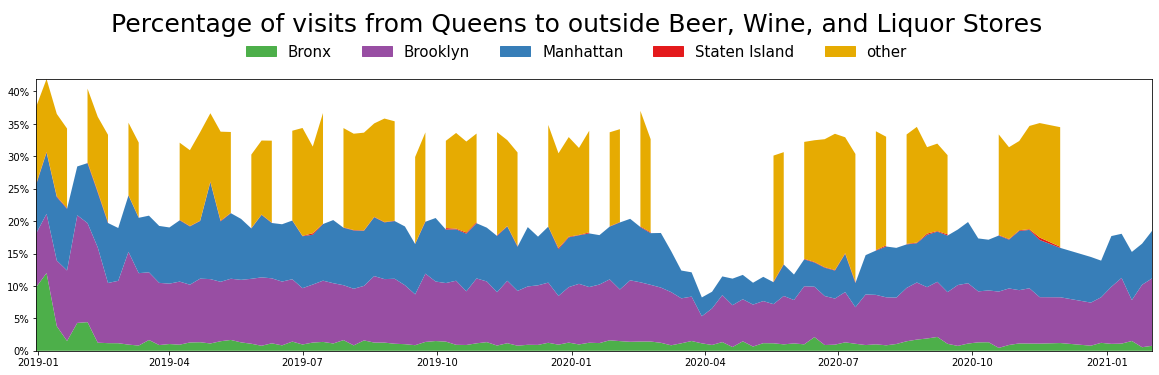

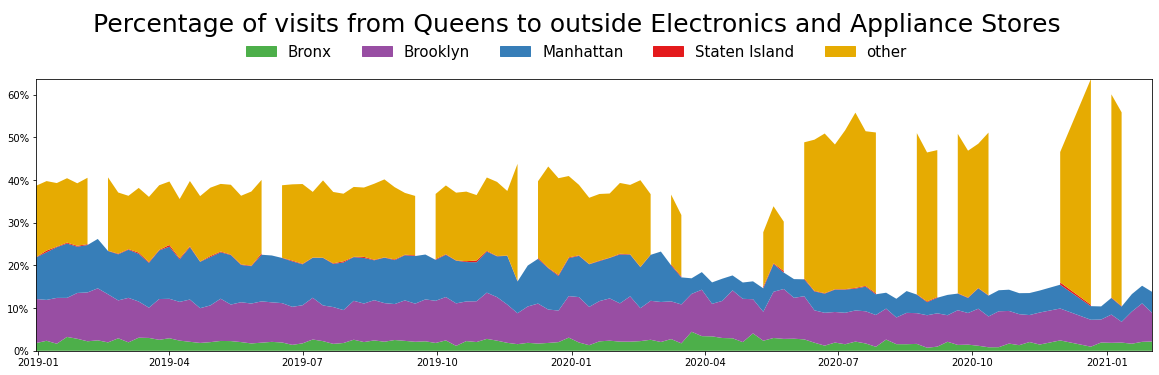

In [50]:
borough = 'Queens'
n = 20

for period in periods:
    sdate = periods[period]['begin-date']
    edate = periods[period]['end-date']
    
    g = df.loc[(df.date >= sdate) & (df.date <= edate) & (df.home_borough == borough) & (df.borough != borough)][['category', 'borough', 'nvisits', 'date']]
    out_visit_cat = g.groupby(['category', 'date']).sum().mean(level=0).sort_values(by='nvisits', ascending=False)
    top_n_cats = out_visit_cat[:n].index
    
    out_visit_cat[:n].to_csv(join(result_visit_pct_dir, f'{period}-{borough}.csv'))
    
    for category in top_n_cats:
        fig_name = join(fig_visit_pct_dir, f'{borough}-{category}.png')
        if not os.path.isfile(fig_name):
            res = df[(df.home_borough == borough) & (df.category == category) & (df.borough != borough)][['borough', 'nvisits_ratio', 'date']]
            res = res.pivot(index='date', columns='borough', values='nvisits_ratio')

            other_boroughs = res.columns
            visit_pcts = res.values.T
            colors = [borough_colors[b] for b in other_boroughs]

            fig, ax = plt.subplots(1, 1, figsize=(20, 5))

            ax.stackplot(res.index, visit_pcts, colors=colors)
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            ax.margins(0, 0)

            fig.legend([mpatches.Patch(color=color) for color in colors],
                        [borough for borough in other_boroughs],
                        loc='center',
                        ncol=len(other_boroughs),
                        bbox_to_anchor=(0.5, 1), 
                        title_fontsize=25,
                        fontsize=15,
                        title=f'Percentage of visits from {borough} to outside {category}', 
                        edgecolor='white',
                        facecolor='white'
                        )

            fig.savefig(fig_name, bbox_inches='tight')